In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [110]:
data = pd.read_csv('AmesHousing.txt', delimiter='\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [106]:
train= data[:1460]
test = data[1460:]

In [88]:
def transform_features(data):
    return data

def select_features(data):
    return data[["Gr Liv Area", "SalePrice"]]

def train_and_test(data):
    train= data[:1460]
    test = data[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include= ['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    linreg = LinearRegression()
    linreg.fit(train[features], train['SalePrice'])
    predictions = linreg.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)

rmse    
    

57088.25161263909

### Feature Engineering

#### Cleaning Feature

In [89]:
# Dropping column with 5% or more missing values 

# Columns with less than 5% missing value
five_pct = data.shape[0] * 0.05
missing = data.isnull().sum() 
missing = missing[missing > five_pct]
missing.index


Index(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')

In [90]:
# Dropping columns with missing values >= 5%
data = data.drop(missing.index, axis = 1)

In [91]:
# Drop text columns with one or more missing value
# Filtering for text column with missing value
text_missing = data.select_dtypes(include=['object']).isnull().sum()
text_missing = text_missing[text_missing > 0]

# Dropping 
data = data.drop(text_missing.index, axis = 1)

In [92]:
# Fill numerical column with the most common value in that column (mode)
num_missing = data.select_dtypes(['int', 'float']).isnull().sum()
num_missing = num_missing[(num_missing < five_pct) & (num_missing > 0)]
num_missing

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [93]:
# Create dictionaries of column and mode value
replace = data[num_missing.index].mode().to_dict(orient='records')[0]
replace

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [94]:
# Fill columns with mode
data = data.fillna(replace)

# Check for missing value again
data.isnull().sum().value_counts()

0    64
dtype: int64

#### Creating Feature

In [97]:
# Create year the house was sold and years since remodel
years_sold = data['Yr Sold'] - data['Year Built']
years_since_remod = data['Yr Sold'] - data['Year Remod/Add']

# Checking for negative result from the new variable
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [98]:
years_since_remod[years_since_remod < 0]


1702   -1
2180   -2
2181   -1
dtype: int64

In [100]:
# Create new column for the new features created 
data['Years Before Sale'] = years_sold
data['Years Since Remod'] = years_since_remod

# Dropping rows with negative values as seen earlier
data = data.drop([1702, 2180, 2181], axis= 0)

# Drop the columns
data = data.drop(['Year Built', 'Year Remod/Add'], axis = 1)

In [101]:
# Drop columns that aren't useful for machine learning
data = data.drop(['PID', 'Order'], axis=1)

# Drop columns that leak data about the final sale
data = data.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)

In [111]:
# Update Function
def transform_features(data):
    five_pct = data.shape[0] * 0.05
    missing = data.isnull().sum() 
    missing = missing[missing > five_pct]
    data = data.drop(missing.index, axis = 1)
    
    text_missing = data.select_dtypes(include=['object']).isnull().sum()
    text_missing = text_missing[text_missing > 0]
    data = data.drop(text_missing.index, axis = 1)
    
    num_missing = data.select_dtypes(['int', 'float']).isnull().sum()
    num_missing = num_missing[(num_missing < five_pct) & (num_missing > 0)]
    replace = data[num_missing.index].mode().to_dict(orient='records')[0]
    data = data.fillna(replace)
    
    years_sold = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_sold
    data['Years Since Remod'] = years_since_remod
    data = data.drop([1702, 2180, 2181], axis= 0)
    
    data = data.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                      'PID', 'Order'], axis=1)
    
    return data

def select_features(data):
    return data[["Gr Liv Area", "SalePrice"]]

def train_and_test(data):
    train= data[:1460]
    test = data[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include= ['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    linreg = LinearRegression()
    linreg.fit(train[features], train['SalePrice'])
    predictions = linreg.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)

rmse    
    

55275.36731241307

### Feature Selection


<AxesSubplot:>

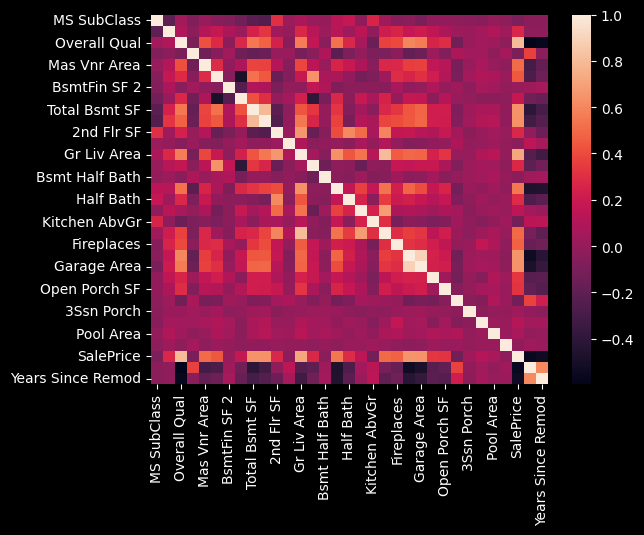

In [128]:
# Heatmap of numerical feature in the training dataset
num_features = transform_data.select_dtypes(['int', 'float'])
corr_mat = num_features.corr()
sb.heatmap(data=corr_mat)

In [129]:
# Heatmap of numerical feature in the training dataset
num_features = transform_data.select_dtypes(['int', 'float'])
corr_mat = num_features.corr()['SalePrice'].abs().sort_values()
corr_mat

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

In [131]:
# Keeping columns with correlation coefficient greater than 0.5
corr_less = corr_mat[corr_mat > 0.5]

In [132]:
# Remove columns with coefficent less than 0.5
transform_data = transform_data.drop(corr_less.index, axis=1)

In [134]:
# List of categorical columns
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [138]:
# Filtering for columns in our tranform data
trans_cat = []
for i in nominal_features:
    if i in transform_data.columns:
        trans_cat.append(i)
        
# Counting unique values in each column
unique_count = transform_data[trans_cat].apply(lambda x: len(x.value_counts())).sort_values()

# Arbitrary cutoff of 10 unique count
unique_count = unique_count[unique_count > 10].index
# Dropping 
transform_data = transform_data.drop(unique_count, axis=1)

In [140]:
# Converting the remaining text column to categorical type
txt_col = transform_data.select_dtypes(include=['object'])
for col in txt_col:
    transform_data[col] = transform_data[col].astype('category')
    
# Creating dummy columns from txt columns and add back to dataframe
transform_data = pd.concat([
    transform_data, pd.get_dummies(transform_data.select_dtypes(include=['category']))
], axis=1).drop(txt_col, axis=1)

In [142]:
# Update Function
def transform_features(data):
    five_pct = data.shape[0] * 0.05
    missing = data.isnull().sum() 
    missing = missing[missing > five_pct]
    data = data.drop(missing.index, axis = 1)
    
    text_missing = data.select_dtypes(include=['object']).isnull().sum()
    text_missing = text_missing[text_missing > 0]
    data = data.drop(text_missing.index, axis = 1)
    
    num_missing = data.select_dtypes(['int', 'float']).isnull().sum()
    num_missing = num_missing[(num_missing < five_pct) & (num_missing > 0)]
    replace = data[num_missing.index].mode().to_dict(orient='records')[0]
    data = data.fillna(replace)
    
    years_sold = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_sold
    data['Years Since Remod'] = years_since_remod
    data = data.drop([1702, 2180, 2181], axis= 0)
    
    data = data.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                      'PID', 'Order'], axis=1)
    
    return data

def select_features(data, corr_coef=0.5, uniq_cutoff=10):
    num_features = data.select_dtypes(['int', 'float'])
    corr_mat = num_features.corr()['SalePrice'].abs().sort_values()
    corr_less = corr_mat[corr_mat < corr_coef]
    data = data.drop(corr_less.index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    trans_cat = []
    for i in nominal_features:
        if i in data.columns:
            trans_cat.append(i)

    unique_count = data[trans_cat].apply(lambda x: len(x.value_counts())).sort_values()
    unique_count = unique_count[unique_count > 10].index
    data = data.drop(unique_count, axis=1)
    
    txt_col = data.select_dtypes(include=['object'])
    for col in txt_col:
        data[col] = data[col].astype('category')

    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['category']))], axis=1).drop(txt_col, axis=1)
    
    return data

def train_and_test(data):
    train= data[:1460]
    test = data[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include= ['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    linreg = LinearRegression()
    linreg.fit(train[features], train['SalePrice'])
    predictions = linreg.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)

rmse    
    

33873.79511846208